## Transfer Learning Tuning:
  * Use Resnet50 to reduce model size and improve accuracy 
      * see [base model info comparison](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
      * [resnet50 blog](https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33)
     
  * base_model: use RESNET50 and freeze at bottleneck layer (stop right before 2D AVERAGE POOL) 
  * top_model: tune dense layers (parameters are inspired by a few sources)
     * [source1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50)
     * [source2](https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras)
     * [source3](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8)



  
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0905 15:23:55.526815 140313200772928 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0905 15:23:55.527781 140313200772928 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



---
#### Import necessary libraries

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras_preprocessing.image import ImageDataGenerator
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## load in custom preprocess function

In [3]:
%load_ext autoreload
%autoreload 1

sys.path.append("../python_files/")

import vgg16_preprocess


%aimport vgg16_preprocess


In [4]:
#  import total dataframe

df = pd.read_pickle('../pickle_files/pic_df.pkl')

In [5]:
# subset a dataframe 
def create_test_train(df,label):
    '''
    df: dateframe of pic_ids 
    label: eyewear,hat, or beard, a string
    return: test and train df
    '''
    sub_set = df[['pic_id',label]]  # subset the label dataframe 
    X_train, X_test, y_train, y_test = train_test_split(sub_set['pic_id'], sub_set[label],
                                                        stratify = sub_set[label],
                                                        test_size = 0.2)
    df_train = pd.concat([X_train,y_train], axis=1)
    df_test = pd.concat([X_test,y_test], axis=1)
    return df_train, df_test
    

In [6]:
def create_generator(train_df, test_df,label,shuffle,batch_size,
                    rescale, preprocess_func, target_size,
                    class_mode, only_testing = False):
    '''
    train_df, test_df: dataframe for train and test 
    label: eyewear,hat, or beard, a string
    shuffle: weather to shuffle or not based upon feature extractor or not 
    batch_size: how many pictures per batch
    preprocess_func: vgg16 preprocess or ResNet50
    rescale: 1./255 or None
    target_size: (224,224) or (150,150)
    class_mode: none or binary 
    return:
    train generator and test generator 
    '''
    generators =[]
    if not only_testing:
        traingen = ImageDataGenerator(
            rescale = rescale,
            zoom_range= [0.8,1.7],
            shear_range=0.2,
            brightness_range=[0.5,1.5],
            rotation_range = 40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            preprocessing_function=preprocess_func)
        
        train_generator = traingen.flow_from_dataframe(
            dataframe=train_df,
            directory='../data/pics',
            x_col='pic_id',
            y_col=label,
            batch_size=batch_size,
            shuffle = shuffle,
            target_size=target_size,
            class_mode = class_mode)
        generators.append(train_generator)
        if class_mode:
        # create classweights for train 
            classweights = class_weight.compute_class_weight(
                'balanced',np.unique(train_generator.classes),train_generator.classes)
            generators.append(classweights)
    
    testgen = ImageDataGenerator(
        rescale = rescale,
        preprocessing_function=preprocess_func)
    
    test_generator = testgen.flow_from_dataframe(
        dataframe=test_df,
        directory='../data/pics',
        x_col='pic_id',
        y_col=label,
        batch_size=batch_size,
        shuffle=shuffle,
        target_size=target_size,
        class_mode=class_mode)
    generators.append(test_generator)
    
    return generators

In [53]:
train_df, test_df = create_test_train(df,'hat')

#### Get bottleneck features to tune top models

In [8]:
def save_bottleneck_features(df, label, batch_size, model_type, preprocess_func, rescale,
                            shuffle,target_size,class_mode):
    '''
    inputs:
    df: dataframe for all eyewear, hat, and beard 
    label: a string, eyewear, hat, or beard
    batch_size: process images in batches
    model_type: ResNet50 or VGG16
    shuffle: weather to shuffle or not based upon feature extractor or not 
    preprocess_func: vgg16 preprocess or ResNet50
    rescale: 1./255 or None
    target_size: (224,224) or (150,150)
    class_mode: none or binary 
    outputs:
    saves bottleneck features inside folder tuning_data as npy file
    '''
    # intialize the model, vgg16 or ResNet50 
    # make sure not to train the top layers 
    base_model = model_type(weights = 'imagenet',include_top = False)
    # generate test_train df
    train_df, test_df = create_test_train(df,label)
    # create train_generator and test_generator to get bottleneck inputs for train and test df 
    # make sure shuffle is False so we know the label follows the sequence of the dataframe 
    # so we can tune top_model 
    generators = create_generator(train_df=train_df,
                                                   test_df=test_df,
                                                   label=label,
                                                   shuffle=shuffle,
                                                   rescale=rescale,
                                                   preprocess_func=preprocess_input,
                                                   batch_size=16,
                                                   target_size=target_size,
                                                   class_mode=class_mode)  
    train_generator, test_generator = generators[0],generators[1]
    
    # get features saved as .npy in tunign_data folder 
    bottleneck_features_train = base_model.predict_generator(
        train_generator, train_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/VGG_16_tuning/bottleneck_features_train_{label}_vgg16_beta.npy','wb'),
           bottleneck_features_train)
    
    bottleneck_features_test = base_model.predict_generator(
        test_generator, test_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/VGG_16_tuning/bottleneck_features_test_{label}_vgg16_beta.npy','wb'),
           bottleneck_features_test)
    return train_df, test_df

#### Save bottleneck_features

In [54]:
train_df, test_df = save_bottleneck_features(df,'hat',16,VGG16,vgg16_preprocess.preprocess_input,
                         1./255,False,(150,150),None)

Found 522 validated image filenames.
Found 131 validated image filenames.


In [ ]:
def resnet50_model(input_shape, dropout):
    '''
    input_shape: input_shape for pooling layer 
    dropout:percentage for Dropout layer 
    optimizer: optimizer for model compiles 
    returns resnet50 model
    '''
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=input_shape))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [10]:
def vgg16_model(input_shape,dropout):
    '''
    input_shape: input_shape for pooling layer 
    dropout:percentage for Dropout layer 
    optimizer: optimizer for model compiles 
    returns vgg16 model
    '''
     # build top model
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    return model    

### Quick tuning of top models 

In [25]:
def train_top_model(train_df, test_df, epoch, batch_size, label, model_type,rescale,preprocess_func,
                   target_size):
    '''
    inputs:
    train_df, test_df: dataframes returned from save_bottleneck_features functions 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    model_type: resnet50 or vgg16
    output:
    saves model weights in a folder 
    '''
    train_data = np.load(open(f'../tuning_data/VGG_16_tuning/bottleneck_features_train_{label}_vgg16_beta.npy','rb'))
    # make sure train_data and train_label have same num of samples
    train_label = np.array(train_df[label].map({'0':0, '1':1}))[:-(train_df.shape[0]%batch_size)]
    
    test_data = np.load(open(f'../tuning_data/VGG_16_tuning/bottleneck_features_test_{label}_vgg16_beta.npy','rb'))
    test_label = np.array(test_df[label].map({'0':0, '1':1}))[:-(test_df.shape[0]%batch_size)]
    
    # build top model
    if model_type == 'resnet50':
        model = resnet50_model(train_data.shape[1:],0.25)
    if model_type == 'vgg16':
        model = vgg16_model(train_data.shape[1:],0.5)
        
    model.compile(optimizer=optimizers.Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    # checkpoint for best weights 
    filepath=f"../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_{label}_beta.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    classweight = create_generator(train_df, test_df,label,False,batch_size,
                    rescale, preprocess_func, target_size,
                    'binary', only_testing = False)[1]
    
    model.fit(train_data, train_label,
             epochs=epoch,
             batch_size=batch_size,
             validation_data=(test_data,test_label),
             callbacks=callbacks_list,
             class_weight = classweight)
    del model
    keras.backend.clear_session()

#### run train_top_model and save results in tuning_data

In [55]:
train_top_model(train_df, test_df, 50, 16, 'hat','vgg16',1./255,vgg16_preprocess.preprocess_input,target_size=(150,150))

Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Train on 512 samples, validate on 128 samples
Epoch 1/50
512/512 [==============================] - 0s 643us/step - loss: 0.7557 - acc: 0.7051 - val_loss: 0.2645 - val_acc: 0.8828

Epoch 00001: val_acc improved from -inf to 0.88281, saving model to ../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_hat_beta.h5
Epoch 2/50
512/512 [==============================] - 0s 215us/step - loss: 0.3650 - acc: 0.8457 - val_loss: 0.2044 - val_acc: 0.9219

Epoch 00002: val_acc improved from 0.88281 to 0.92188, saving model to ../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_hat_beta.h5
Epoch 3/50
512/512 [==============================] - 0s 211us/step - loss: 0.2948 - acc: 0.8750 - val_loss: 0.2935 - val_acc: 0.8984

Epoch 00003: val_acc did not improve from 0.92188
Epoch 4/50
512/512 [==============================] - 0s 210us/step - loss: 0.1793 - acc: 0.9316 - val

512/512 [==============================] - 0s 222us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.3305 - val_acc: 0.8984

Epoch 00043: val_acc did not improve from 0.92188
Epoch 44/50
512/512 [==============================] - 0s 220us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3376 - val_acc: 0.9062

Epoch 00044: val_acc did not improve from 0.92188
Epoch 45/50
512/512 [==============================] - 0s 219us/step - loss: 9.4110e-04 - acc: 1.0000 - val_loss: 0.3265 - val_acc: 0.8984

Epoch 00045: val_acc did not improve from 0.92188
Epoch 46/50
512/512 [==============================] - 0s 238us/step - loss: 9.4430e-04 - acc: 1.0000 - val_loss: 0.4434 - val_acc: 0.8984

Epoch 00046: val_acc did not improve from 0.92188
Epoch 47/50
512/512 [==============================] - 0s 223us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.8906

Epoch 00047: val_acc did not improve from 0.92188
Epoch 48/50
512/512 [==============================] - 0s 210us/step - los

### Fine Tune Top Model to improve accuracy

In [13]:
def fine_tune_model(train_df, test_df,epoch, batch_size,label, 
                    model_type,dim, rescale, preprocess_func,print_model = False):
    '''
    inputs:
    train_df, test_df: dataframes returned from save_bottleneck_features functions 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    model_type: resnet50 or vgg16
    dim: 224 or 150 
    rescale: None resnet50, 1./255 for vgg16
    preprocess_func: depends on resnet or vgg16
    return model 
    '''
    # build model and freeze top layers
    # input_shape: width, height, RGB (from image generator)
    if model_type == 'resnet50':
        base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(dim,dim,3))
        # build top model
        top_model = resnet50_model(base_model.output_shape[1:],0.25)
    if model_type == 'vgg16':
        base_model = VGG16(weights='imagenet',include_top=False, input_shape=(dim,dim,3))
        top_model = vgg16_model(base_model.output_shape[1:],0.5)
    # load saved weights to fine tune parameters 
    top_model.load_weights(f'../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_{label}_beta.h5')
    # add top model to model
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    # we will tune last 8 layers of the model: activation49 and fully connected layer 
    for layer in model.layers[:-5]:
        layer.trainable = False
    # we can tune the parameters for lr and momentum later to get better results
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=5e-5, momentum = 0.9),
             metrics=['accuracy'])
    # prepare train generator using data augmentation to battle small sample size 
    generators = create_generator(train_df,test_df, label,True,16,rescale,
                                                    preprocess_func,(dim,dim),
                                                    'binary')
    train_generator, classweight, test_generator = generators[0], generators[1], generators[2]
    
    # checkpoint for best weights 
    filepath=f"../tuning_data/VGG_16_tuning/best_vgg16_model_5_layer_{label}_beta.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # run and fit model 
    result = model.fit_generator(
    train_generator,
    steps_per_epoch=train_df.shape[0]//batch_size,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=test_df.shape[0]//batch_size,
    verbose=1,class_weight=list(classweight),
    callbacks=callbacks_list
    )
    
    if print_model:
        model.summary()
    
    del model
    keras.backend.clear_session()
    return result                

### save model history 

In [56]:
model_history = fine_tune_model(train_df,test_df,50,16,'hat','vgg16',
                                150,1./255,vgg16_preprocess.preprocess_input)

Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Epoch 1/50
32/32 [==============================] - 5s 154ms/step - loss: 0.3954 - acc: 0.8501 - val_loss: 0.3525 - val_acc: 0.8672

Epoch 00001: val_acc improved from -inf to 0.86719, saving model to ../tuning_data/VGG_16_tuning/best_vgg16_model_5_layer_hat_beta.h5
Epoch 2/50
32/32 [==============================] - 5s 167ms/step - loss: 0.4117 - acc: 0.8286 - val_loss: 0.1943 - val_acc: 0.9130

Epoch 00002: val_acc improved from 0.86719 to 0.91304, saving model to ../tuning_data/VGG_16_tuning/best_vgg16_model_5_layer_hat_beta.h5
Epoch 3/50
32/32 [==============================] - 5s 161ms/step - loss: 0.3840 - acc: 0.8406 - val_loss: 0.2846 - val_acc: 0.8696

Epoch 00003: val_acc did not improve from 0.91304
Epoch 4/50
32/32 [==============================] - 5s 153ms/step - loss: 0.3902 - acc: 0.8434 - val_loss: 0.1664 - val_acc: 0.9478

Epoch 00004: val_acc improv

32/32 [==============================] - 5s 146ms/step - loss: 0.1583 - acc: 0.9442 - val_loss: 0.1218 - val_acc: 0.9478

Epoch 00042: val_acc did not improve from 0.97391
Epoch 43/50
32/32 [==============================] - 4s 136ms/step - loss: 0.1814 - acc: 0.9297 - val_loss: 0.0746 - val_acc: 0.9565

Epoch 00043: val_acc did not improve from 0.97391
Epoch 44/50
32/32 [==============================] - 5s 154ms/step - loss: 0.1596 - acc: 0.9411 - val_loss: 0.1469 - val_acc: 0.9217

Epoch 00044: val_acc did not improve from 0.97391
Epoch 45/50
32/32 [==============================] - 4s 140ms/step - loss: 0.1892 - acc: 0.9282 - val_loss: 0.0841 - val_acc: 0.9652

Epoch 00045: val_acc did not improve from 0.97391
Epoch 46/50
32/32 [==============================] - 5s 146ms/step - loss: 0.1850 - acc: 0.9297 - val_loss: 0.1074 - val_acc: 0.9609

Epoch 00046: val_acc did not improve from 0.97391
Epoch 47/50
32/32 [==============================] - 5s 165ms/step - loss: 0.1628 - acc: 0.9

In [61]:
highest_val_acc, highest_train_acc = max(model_history.history['val_acc']), max(model_history.history['acc'])
print(f'highest test accuracy: {highest_val_acc}')
print('------------------')
print(f'highest train accuracy: {highest_train_acc}')

highest test accuracy: 0.9739130434782609
------------------
highest train accuracy: 0.9565217391304348


In [62]:
lowest_val_loss, lowest_train_loss = min(model_history.history['val_loss']), min(model_history.history['loss'])
print(f'lowest test loss: {lowest_val_loss}')
print('------------------')
print(f'lowest train loss: {lowest_train_loss}')

lowest test loss: 0.07462257716966712
------------------
lowest train loss: 0.13388301167092304


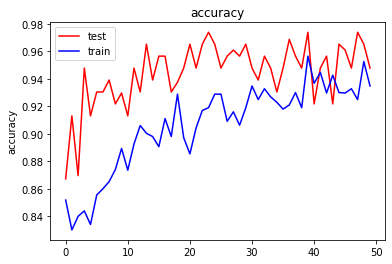

In [63]:
plt.plot(model_history.history['val_acc'], color = 'red', label = 'test')
plt.plot(model_history.history['acc'], color = 'blue', label = 'train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.show()

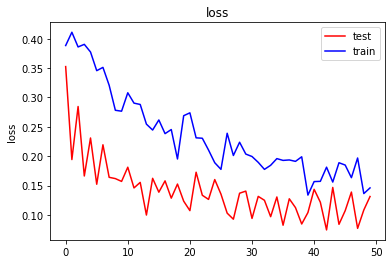

In [64]:
plt.plot(model_history.history['val_loss'], color = 'red', label = 'test')
plt.plot(model_history.history['loss'], color = 'blue', label = 'train')
plt.title('loss')
plt.ylabel('loss')
plt.legend()
plt.show()

### Save model 

In [ ]:
# # save model artchitecture 
# resnet50_model_8_up = model_history.model
# resnet50_model_8_up_json = resnet50_model_8_up.to_json()

In [ ]:
# # serialize model to JSON
# with open("../tuning_data/resnet_data/resnet50_model_8_up.json", "w") as json_file:
#     json_file.write(resnet50_model_8_up_json)

### Testing model

In [21]:
# load json and create model
def model_testing(df, model_path, weight_path, label,target_size,shuffle = False,
                 batch_size = 32, rescale=None,preprocess_func=preprocess_input,
                 class_mode ='binary', only_testing = True, old =False):
    '''
    df: the entire picture df 
    model_path: json model path
    weight_path: path for weights 
    label: eyewear, hat, or beard
    '''
    # check the whole dataframe
    sub_set = df[['pic_id',label]] 
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load model weight yewear_decay_
    loaded_model.load_weights(weight_path)
    # test test data
    data_generator= create_generator(None, df,label,shuffle,batch_size,
                    rescale, preprocess_func, target_size,
                    class_mode, only_testing = only_testing)
    data_generator=data_generator[0]
    labels = df[label].map({'1':1, '0':0})
    
    loaded_model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(),
             metrics=['accuracy']
                        )
    y_pred = np.around(loaded_model.predict_generator(data_generator, workers=8))
    if old:
        y_pred = [1-x for x in y_pred] # for old model 
    fpr, tpr, thresholds = roc_curve(labels, y_pred)
    area = roc_auc_score(labels, y_pred)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % area)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print(confusion_matrix(labels, y_pred))
    print(classification_report(labels, y_pred))    

### Eyewear

W0905 15:35:21.962489 140313200772928 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Found 653 validated image filenames belonging to 2 classes.


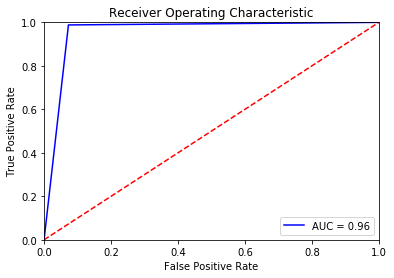

[[293  23]
 [  4 333]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       316
           1       0.94      0.99      0.96       337

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



In [32]:
model_testing(df=df,model_path='../tuning_data/resnet_data/resnet50_model_5_up.json',
             weight_path='../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_5_layer_eyewear_0.25dobeta_1.h5',
              label='eyewear',target_size=(224,224), old = False)
# use best_resnet50_model_5_layer_eyewear_0.25dobeta_1.h5

Found 653 validated image filenames belonging to 2 classes.


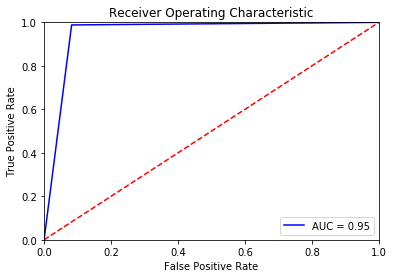

[[290  26]
 [  4 333]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       316
           1       0.93      0.99      0.96       337

    accuracy                           0.95       653
   macro avg       0.96      0.95      0.95       653
weighted avg       0.96      0.95      0.95       653



In [33]:
model_testing(df,'../tuning_data/resnet_data/resnet50_model_5_up.json', 
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_eyewear.h5',
              'eyewear',(224,224), old = True)

Found 653 validated image filenames belonging to 2 classes.


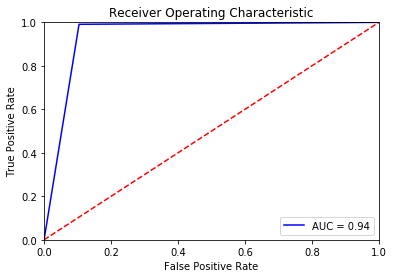

[[283  33]
 [  3 334]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       316
           1       0.91      0.99      0.95       337

    accuracy                           0.94       653
   macro avg       0.95      0.94      0.94       653
weighted avg       0.95      0.94      0.94       653



In [34]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg16_model_5_layer_eyewear_beta.h5',
              'eyewear',(150,150), old = False)

Found 653 validated image filenames belonging to 2 classes.


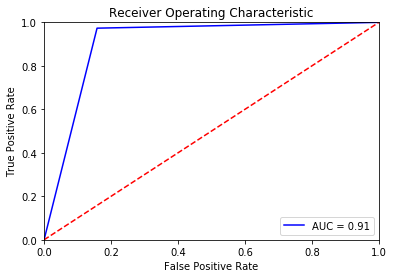

[[266  50]
 [  9 328]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       316
           1       0.87      0.97      0.92       337

    accuracy                           0.91       653
   macro avg       0.92      0.91      0.91       653
weighted avg       0.92      0.91      0.91       653



In [35]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg_model_eyewears.h5',
              'eyewear',(150,150), old = True)

### Testing hat 

Found 653 validated image filenames belonging to 2 classes.


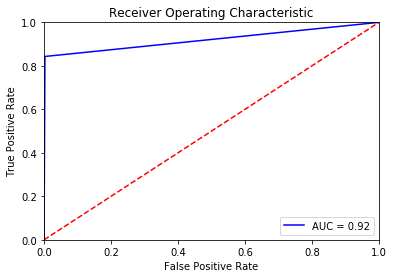

[[397   1]
 [ 40 215]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       398
           1       1.00      0.84      0.91       255

    accuracy                           0.94       653
   macro avg       0.95      0.92      0.93       653
weighted avg       0.94      0.94      0.94       653



In [68]:
model_testing(df=df,model_path='../tuning_data/resnet_data/resnet50_model_5_up.json',
             weight_path='../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_5_layer_hat_0.25dobeta_1.h5',
              label='hat', target_size=(224,224),old = False)

Found 653 validated image filenames belonging to 2 classes.


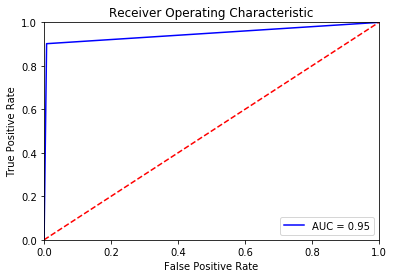

[[395   3]
 [ 25 230]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       398
           1       0.99      0.90      0.94       255

    accuracy                           0.96       653
   macro avg       0.96      0.95      0.95       653
weighted avg       0.96      0.96      0.96       653



In [69]:
model_testing(df,'../tuning_data/resnet_data/resnet50_model_5_up.json', 
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_hat.h5',
             'hat',(224,224),old = True)

# best resnet

Found 653 validated image filenames belonging to 2 classes.


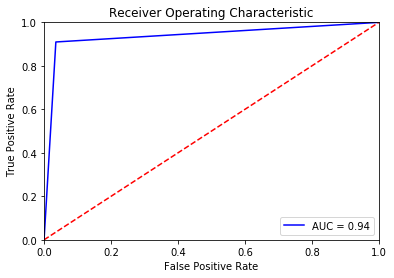

[[384  14]
 [ 23 232]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       398
           1       0.94      0.91      0.93       255

    accuracy                           0.94       653
   macro avg       0.94      0.94      0.94       653
weighted avg       0.94      0.94      0.94       653



In [70]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg16_model_5_layer_hat_beta.h5',
              'hat',(150,150),old = False)

Found 653 validated image filenames belonging to 2 classes.


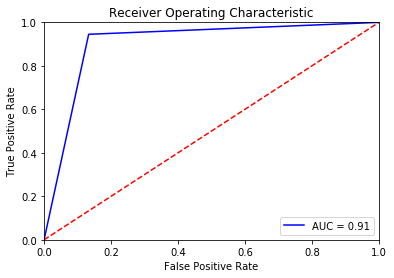

[[345  53]
 [ 14 241]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       398
           1       0.82      0.95      0.88       255

    accuracy                           0.90       653
   macro avg       0.89      0.91      0.89       653
weighted avg       0.91      0.90      0.90       653



In [71]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg_model_hat.h5',
              'hat',(150,150), old = True)

### Testing beard

Found 653 validated image filenames belonging to 2 classes.


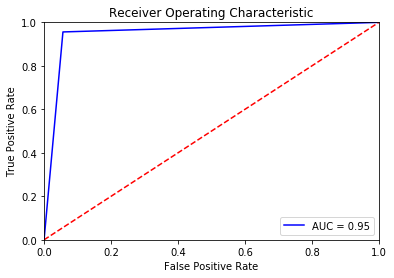

[[402  24]
 [ 10 217]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       426
           1       0.90      0.96      0.93       227

    accuracy                           0.95       653
   macro avg       0.94      0.95      0.94       653
weighted avg       0.95      0.95      0.95       653



In [38]:
model_testing(df=df,model_path='../tuning_data/resnet_data/resnet50_model_5_up.json',
             weight_path='../tuning_data/resnet_data/untracked_resnet50/resnet50_model_5_layer_beard_0.25dobeta_1.h5',
              label='beard', target_size = (224,224), old = False)

Found 653 validated image filenames belonging to 2 classes.


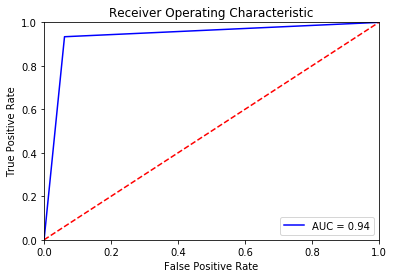

[[400  26]
 [ 15 212]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       426
           1       0.89      0.93      0.91       227

    accuracy                           0.94       653
   macro avg       0.93      0.94      0.93       653
weighted avg       0.94      0.94      0.94       653



In [42]:
model_testing(df,'../tuning_data/resnet_data/resnet50_model_5_up.json',
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_beard.h5','beard',(224,224),old = True)

Found 653 validated image filenames belonging to 2 classes.


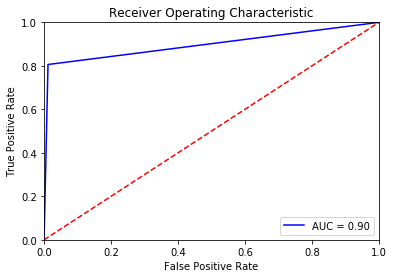

[[421   5]
 [ 44 183]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       426
           1       0.97      0.81      0.88       227

    accuracy                           0.92       653
   macro avg       0.94      0.90      0.91       653
weighted avg       0.93      0.92      0.92       653



In [52]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg16_model_5_layer_beard_beta.h5',
              'beard',(150,150),old = False)

Found 653 validated image filenames belonging to 2 classes.


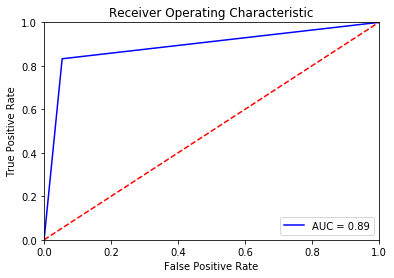

[[403  23]
 [ 38 189]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       426
           1       0.89      0.83      0.86       227

    accuracy                           0.91       653
   macro avg       0.90      0.89      0.90       653
weighted avg       0.91      0.91      0.91       653



In [41]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg_model_beard.h5',
              'beard',(150,150), old = True)